# MULTI-CLASS SENTIMENT ANALYSIS USING ATTENTION MODELS TO CLASSIFY SOCIAL MEDIA COMMENTS
---

## MSc Data Analytics for Business by Zuñiga Santillan, Jose Renato
---

### Code to run when Kernel crashes
---

Based on experience, something the kernel crashes when trying to train the model. If so, run the following lines of code until the EDA

In [ ]:
conda install pytorch torchvision -c pytorch

In [ ]:
!pip3 install torch torchvision

In [ ]:
!pip install torchvision

In [ ]:
conda update -n base -c defaults conda

In [ ]:
!pip install tensorflow

In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

If everything is ok, this code will assess if torch is correctly installed

In [2]:
import torch
x = torch.rand(5, 3)
print(x)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 24.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


## Exploratory Data Analysis (EDA)
---

### EDA on first dataset
---

Note: All the files are saved locally

In [258]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [259]:
df = pd.read_csv('/Users/renatozuniga/Downloads/tweet_emotions.csv', delimiter=',')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


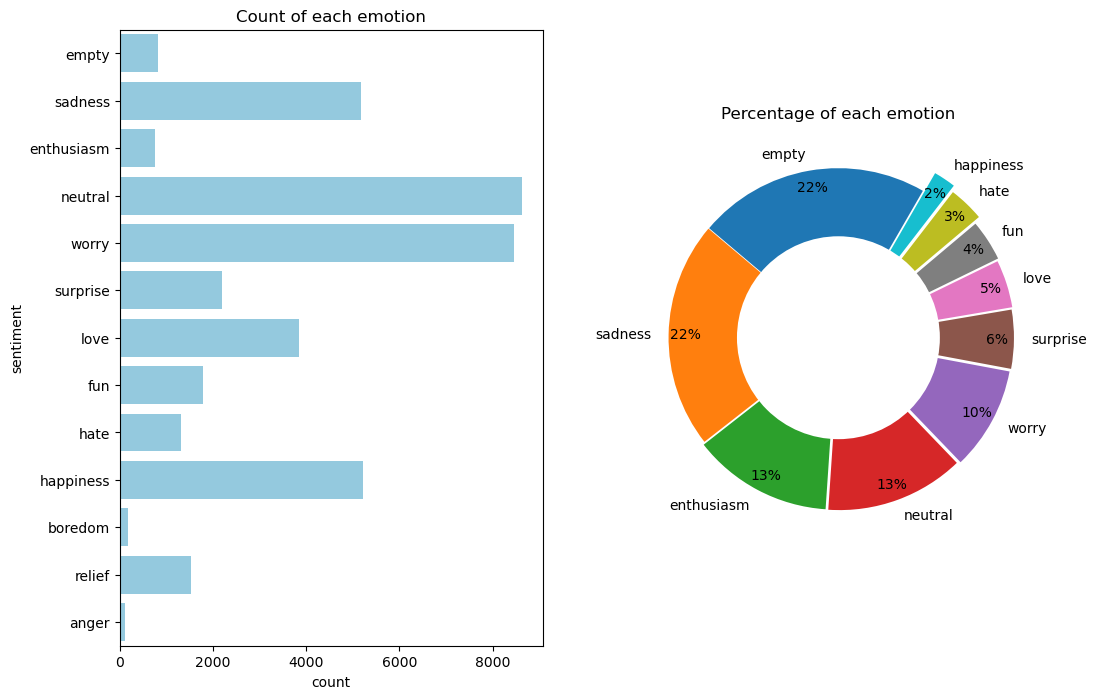

In [260]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1, color='skyblue')
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [261]:
df['sentiment'] = df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love', 'surprise'] else "other") 

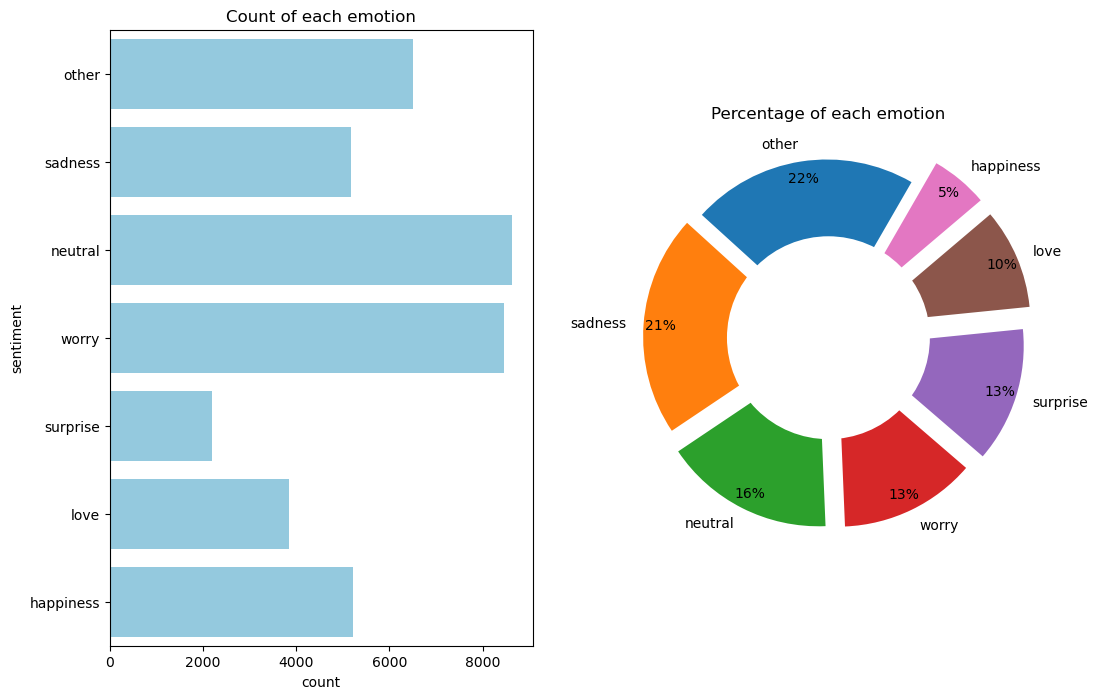

In [262]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1, color='skyblue')
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [263]:
df['tweet_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

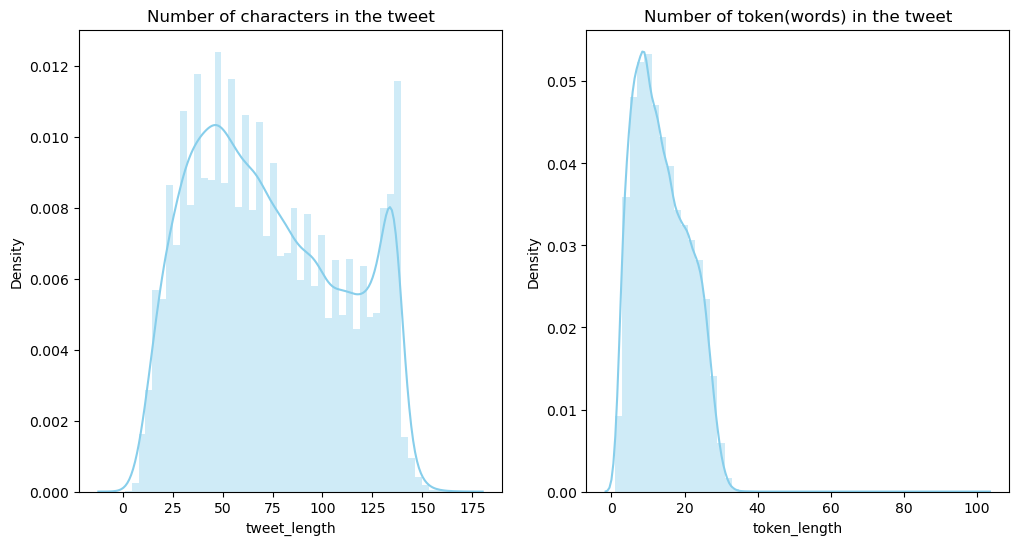

In [264]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['tweet_length'], ax=ax1, color='skyblue')
sns.distplot(df['token_length'], ax=ax2, color='skyblue')
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

In [265]:
avg_df = df.groupby('sentiment').agg({'tweet_length':'mean', 'token_length':'mean'})

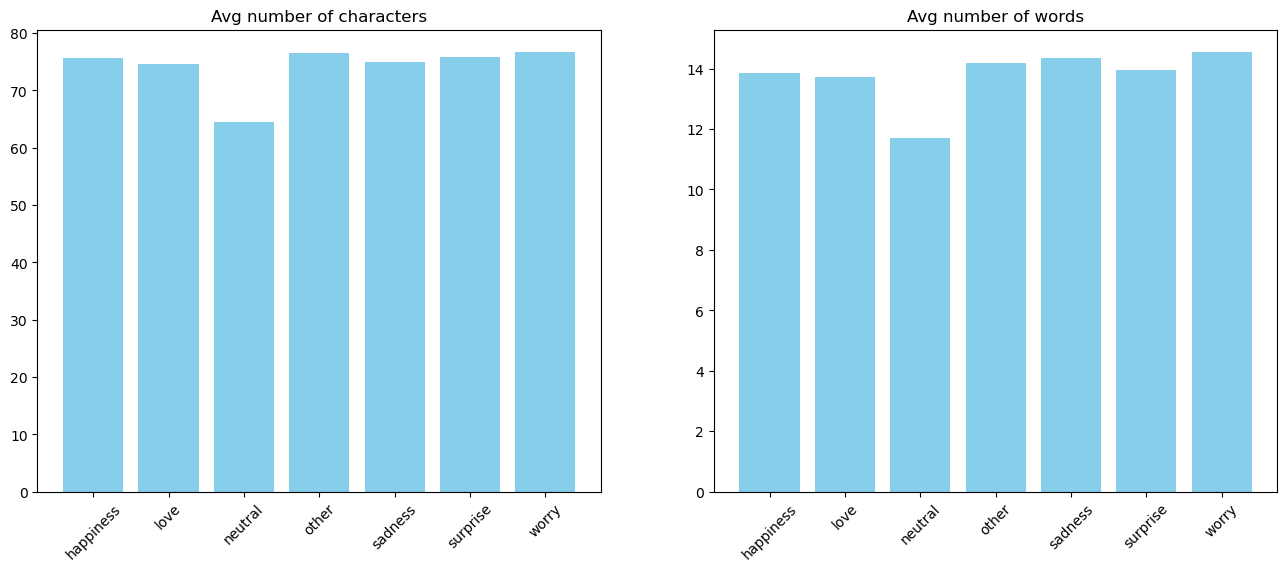

In [266]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['tweet_length'], color='skyblue')
ax2.bar(avg_df.index, avg_df['token_length'], color='skyblue')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of words')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

### EDA on second dataset (used to train and test the model)
---

In [267]:
# Read datasets
df_train = pd.read_csv('/Users/renatozuniga/Downloads/archive (2)/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/Users/renatozuniga/Downloads/archive (2)/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/Users/renatozuniga/Downloads/archive (2)/test.txt', names=['Text', 'Emotion'], sep=';')

In [268]:
df_train.dropna(subset=['Emotion'], inplace=True)
df_val.dropna(subset=['Emotion'], inplace=True)
df_test.dropna(subset=['Emotion'], inplace=True)

In [269]:
df_final = pd.concat([df_train, df_val, df_test])

In [270]:
df_final.Emotion.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Emotion, dtype: int64

In [271]:
df_final.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


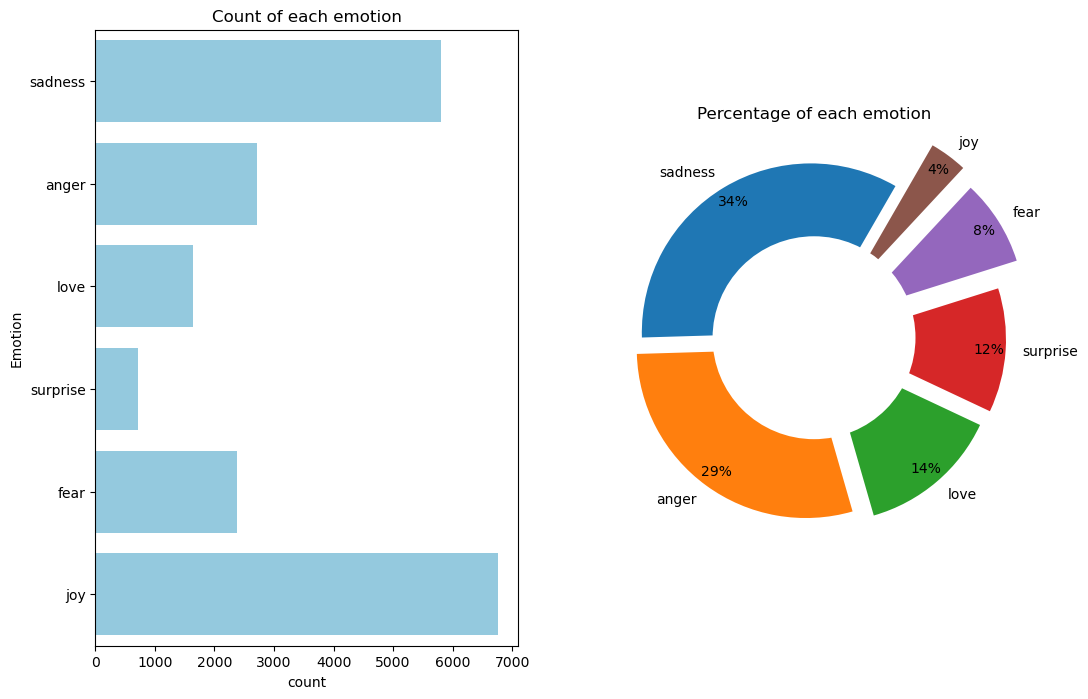

In [272]:
col = 'Emotion'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df_final[col].dropna().value_counts()))/sum(list(df_final[col].dropna().value_counts())))[::-1])[:10]
labels = list(df_final[col].dropna().unique())[:10]
sizes = df_final[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df_final, ax=ax1, color='skyblue')
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [273]:
df_final['Emotion'] = df_final['Emotion'].apply(lambda x : x if x in ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'] else "other") 

In [274]:
df_final['tweet_length'] = df_final['Emotion'].apply(lambda x : len(x))
df_final['token_length'] = df_final['Emotion'].apply(lambda x : len(x.split(" ")))

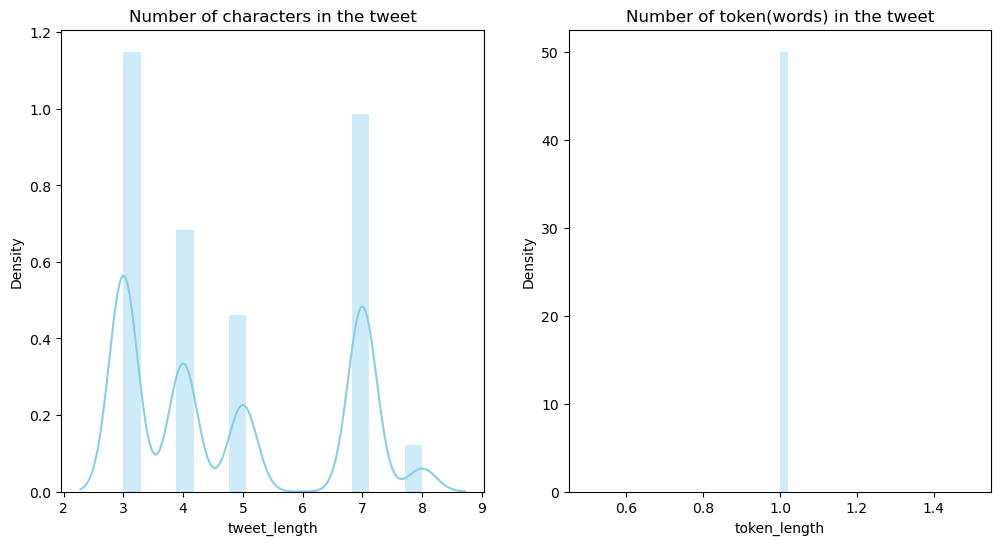

In [275]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df_final['tweet_length'], ax=ax1, color='skyblue')
sns.distplot(df_final['token_length'], ax=ax2, color='skyblue')
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

In [276]:
avg_df = df_final.groupby('Emotion').agg({'tweet_length':'mean', 'token_length':'mean'})

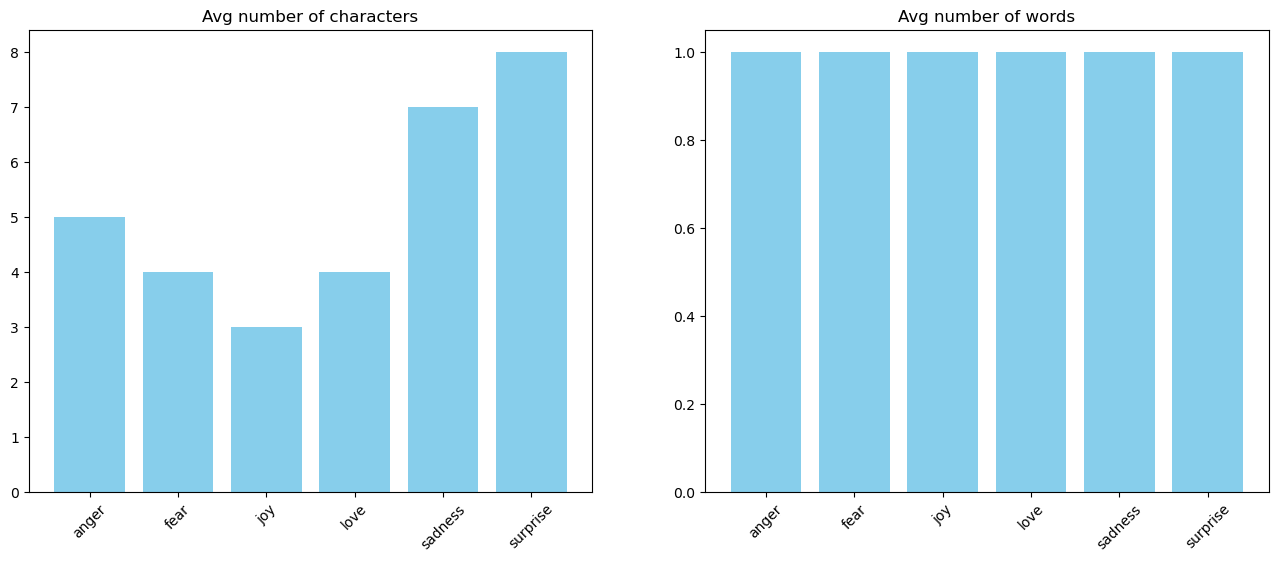

In [277]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['tweet_length'], color='skyblue')
ax2.bar(avg_df.index, avg_df['token_length'], color='skyblue')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of words')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

## Model building
---

In [278]:
import re
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [298]:
lr = 0.001 #Learning rate
vec_len = 50
seq_len = 20
num_epochs = 60 #Number of loops
label_col_1 = 'sentiment'
label_col_2 = 'Emotion'
tokens_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/tokens.pkl"
labels_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/labels.pkl"
data_path_1 = "/Users/renatozuniga/Downloads/Attention_Model/Input/complaints.csv"
data_path_2 = "/Users/renatozuniga/Downloads/tweet_emotions.csv"
model_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/attention.pth"
vocabulary_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/vocabulary.pkl"
embeddings_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/embeddings.pkl"
glove_vector_path = "/Users/renatozuniga/Downloads/Attention_Model/Input/glove.6B.50d.txt"
text_col_name_1 = 'content'
text_col_name_2 = 'Text'
label_encoder_path = "/Users/renatozuniga/Downloads/Attention_Model/Output/label_encoder.pkl"
sentiment_map = {'empty': 'others',
               'sadness': 'sadness',
               'enthusiasm': 'others',
               'neutral': 'neutral',
               'worry': 'worry',
               'surprise': 'surprise',
               'love': 'love',
               'fun': 'fun',
               'hate': 'others',
               'happiness': 'happiness',
               'boredom': 'others',
               'relief': 'others',
               'anger': 'others'}

In [299]:
def save_file(name, obj):
    """
    Function to save an object as pickle file
    """
    with open(name, 'wb') as f:
        pickle.dump(obj, f)


def load_file(name):
    """
    Function to load a pickle object
    """
    return pickle.load(open(name, "rb"))

## Process glove embeddings
---


In [ ]:
with open(glove_vector_path, "rt") as f:
    emb = f.readlines()

In [301]:
vocabulary, embeddings = [], []

for item in emb:
    vocabulary.append(item.split()[0])
    embeddings.append(item.split()[1:])

In [302]:
embeddings = np.array(embeddings, dtype=np.float32)

In [303]:
vocabulary = ["<pad>", "<unk>"] + vocabulary

In [304]:
embeddings = np.vstack([np.ones(50, dtype=np.float32), 
                        np.mean(embeddings, axis=0),
                        embeddings])

In [305]:
save_file(embeddings_path, embeddings)
save_file(vocabulary_path, vocabulary)

## Process text data
---

In [306]:
data = df

In [307]:
data.dropna(subset=[text_col_name_1], inplace=True) #Drop NA values

In [309]:
data.replace({label_col: sentiment_map}, inplace=True)

### Encode labels

In [310]:
label_encoder = LabelEncoder()
label_encoder.fit(data[label_col_1])
labels = label_encoder.transform(data[label_col_1])

In [311]:
save_file(labels_path, labels)
save_file(label_encoder_path, label_encoder)

In [312]:
print(labels)

[3 4 4 ... 1 0 1]


### Process the text column


In [313]:
input_text = list(data[text_col_name_1])

In [314]:
len(input_text)

40000

### Convert text to lower case

In [315]:
input_text = [i.lower() for i in tqdm(input_text)]

100%|████████████████████████████████| 40000/40000 [00:00<00:00, 1033996.65it/s]


### Remove punctuations except apostrophe

In [316]:
input_text = [re.sub(r"[^\w\d'\s]+", " ", i) 
              for i in tqdm(input_text)]

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 239983.75it/s]


### Remove digits

In [317]:
input_text = [re.sub("\d+", "", i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 331438.46it/s]


### Remove more than one consecutive instance of 'x'

In [318]:
input_text = [re.sub(r'[x]{2,}', "", i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 378558.40it/s]


### Remove multiple spaces with single space

In [319]:
input_text = [re.sub(' +', ' ', i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 215038.75it/s]


### Tokenize the text

In [320]:
tokens = [word_tokenize(t) for t in tqdm(input_text)]

100%|███████████████████████████████████| 40000/40000 [00:04<00:00, 8003.01it/s]


### Take the first 20 tokens in each complaint text

In [321]:
print(tokens[1])

['layin', 'n', 'bed', 'with', 'a', 'headache', 'ughhhh', 'waitin', 'on', 'your', 'call']


In [322]:
tokens = [i[:20] if len(i) > 19 else ['<pad>'] * (20 - len(i)) + i 
          for i in tqdm(tokens)]

100%|█████████████████████████████████| 40000/40000 [00:00<00:00, 522174.82it/s]


### Convert tokens to integer indices from vocabulary

In [323]:
def token_index(tokens, vocabulary, missing='<unk>'):
    idx_token = []
    for text in tqdm(tokens):
        idx_text = []
        for token in text:
            if token in vocabulary:
                idx_text.append(vocabulary.index(token))
            else:
                idx_text.append(vocabulary.index(missing))
        idx_token.append(idx_text)
    return idx_token

In [324]:
tokens = token_index(tokens, vocabulary)

100%|███████████████████████████████████| 40000/40000 [3:10:14<00:00,  3.50it/s]


### Save the tokens


In [330]:
save_file(tokens_path, tokens)

## Create attention model
---

In [331]:
class AttentionModel(nn.Module):

    def __init__(self, vec_len, seq_len, n_classes):
        super(AttentionModel, self).__init__()
        self.vec_len = vec_len
        self.seq_len = seq_len
        self.attn_weights = torch.cat([torch.tensor([[0.]]),
                                       torch.randn(vec_len, 1) /
                                       torch.sqrt(torch.tensor(vec_len))])
        self.attn_weights.requires_grad = True
        self.attn_weights = nn.Parameter(self.attn_weights)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm((vec_len + 1,))
        
        self.linear1 = nn.Linear(vec_len + 1, 5000)
        self.norm2 = nn.LayerNorm((5000,))
        self.linear2 = nn.Linear(5000, 2000)
        self.norm3 = nn.LayerNorm((2000,))
        self.linear3 = nn.Linear(2000, 1000)
        self.norm4 = nn.LayerNorm((1000,))
        self.linear4 = nn.Linear(1000, n_classes)

    def forward(self, input_data):
        hidden = torch.matmul(input_data, self.attn_weights)
        hidden = self.activation(hidden)
        attn = self.softmax(hidden)
        attn = attn.repeat(1, 1, self.vec_len + 1).reshape(attn.shape[0],
                                                           self.seq_len,
                                                           self.vec_len + 1)
        attn_output = input_data * attn
        attn_output = torch.sum(attn_output, axis=1)
        
        attn_output = self.norm1(attn_output)
        attn_output = self.dropout(attn_output)
        
        hidden_output = self.linear1(attn_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm2(hidden_output)
        hidden_output = self.dropout(hidden_output)
        
        hidden_output = self.linear2(hidden_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm3(hidden_output)
        hidden_output = self.dropout(hidden_output)
        
        hidden_output = self.linear3(hidden_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm4(hidden_output)
        output = self.linear4(hidden_output)
        
        return output

## Create PyTorch dataset
---

In [332]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, tokens, embeddings, labels):
        self.tokens = tokens
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[self.tokens[idx], :])
        input_ = torch.cat((torch.ones(emb.shape[0],1), emb), dim=1)
        return torch.tensor(self.labels[idx]), input_

### Function to train the model

In [333]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          device, num_epochs, model_path):
    best_loss = 1e8
    epoch_train_losses = []
    epoch_valid_losses = []

    for i in range(num_epochs):
        print(f"Epoch {i+1} of {num_epochs}")
        valid_loss, train_loss = [], []
        model.train()
        # Train loop
        for batch_labels, batch_data in tqdm(train_loader):
            batch_labels = batch_labels.to(device)
            batch_data = batch_data.to(device)
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            loss = criterion(batch_output, batch_labels)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        # Validation loop
        for batch_labels, batch_data in tqdm(valid_loader):
            batch_labels = batch_labels.to(device)
            batch_data = batch_data.to(device)
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            loss = criterion(batch_output, batch_labels)
            valid_loss.append(loss.item())

        t_loss = np.mean(train_loss)
        v_loss = np.mean(valid_loss)
        epoch_train_losses.append(t_loss)
        epoch_valid_losses.append(v_loss)

        print(f"Train Loss: {t_loss}, Validation Loss: {v_loss}")

        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), model_path)

        print(f"Best Validation Loss: {best_loss}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_train_losses, label='Training Loss')
    plt.plot(epoch_valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.show()

### Function to test the model

In [334]:
from sklearn.metrics import f1_score

def test(test_loader, model, criterion, device, num_classes):
    model.eval()
    test_loss = []
    true_labels = []
    predicted_labels = []

    # Initialize arrays to store precision, recall, and F1 score for each class
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for batch_labels, batch_data in tqdm(test_loader):
        # Move data to device
        batch_labels = batch_labels.to(device)
        batch_data = batch_data.to(device)
        # Forward pass
        batch_output = model(batch_data)
        batch_output = torch.squeeze(batch_output)
        # Calculate loss
        loss = criterion(batch_output, batch_labels)
        test_loss.append(loss.item())
        batch_preds = torch.argmax(batch_output, axis=1)
        # Move predictions to CPU
        if torch.cuda.is_available():
            batch_labels = batch_labels.cpu()
            batch_preds = batch_preds.cpu()
        # Collect true and predicted labels
        true_labels.extend(batch_labels.detach().numpy())
        predicted_labels.extend(batch_preds.detach().numpy())

    test_loss = np.mean(test_loss)
    print(f"Test Loss: {test_loss}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate precision, recall, and F1 score for each class
    for i in range(num_classes):
        precision = precision_score(true_labels, predicted_labels, labels=[i], average='micro')
        recall = recall_score(true_labels, predicted_labels, labels=[i], average='micro')
        f1 = f1_score(true_labels, predicted_labels, labels=[i], average='micro')
        precision_per_class.append(precision)
        recall_per_class.append(recall)
        
        f1_per_class.append(f1)

    print("Precision per class:", precision_per_class)
    print("Recall per class:", recall_per_class)
    print("F1 score per class:", f1_per_class)

## Train attention model
---

### Load the files

In [335]:
tokens = load_file(tokens_path)
labels = load_file(labels_path)
embeddings = load_file(embeddings_path)
label_encoder = load_file(label_encoder_path)
num_classes = len(label_encoder.classes_)
vocabulary = load_file(vocabulary_path)

### Split dataset into train, validation and test sets

In [336]:
X_train, X_test, y_train, y_test = train_test_split(tokens, labels,
                                                    test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train,
                                                     test_size=0.25)

### Create PyTorch datasets

In [337]:
train_dataset = TextDataset(X_train, embeddings, y_train)
valid_dataset = TextDataset(X_valid, embeddings, y_valid)
test_dataset = TextDataset(X_test, embeddings, y_test)

### Create data loaders

In [338]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=120,
                                           shuffle=True, 
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=120)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=120)

In [339]:
# Order for the confusion matrix
class_order = data['sentiment'].unique()
print("Order of classes:", class_order)

Order of classes: ['other' 'sadness' 'neutral' 'worry' 'surprise' 'love' 'happiness']


### Create model object

In [340]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

In [341]:
model = AttentionModel(vec_len, seq_len, num_classes)

### Visualize model architecture

In [342]:
print(model)

AttentionModel(
  (activation): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (norm1): LayerNorm((51,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=51, out_features=5000, bias=True)
  (norm2): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=5000, out_features=2000, bias=True)
  (norm3): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
  (linear3): Linear(in_features=2000, out_features=1000, bias=True)
  (norm4): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (linear4): Linear(in_features=1000, out_features=7, bias=True)
)


In [343]:
summary(model, input_size=(seq_len, vec_len + 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1                [-1, 20, 1]               0
           Softmax-2                [-1, 20, 1]               0
         LayerNorm-3                   [-1, 51]             102
           Dropout-4                   [-1, 51]               0
            Linear-5                 [-1, 5000]         260,000
              ReLU-6                 [-1, 5000]               0
         LayerNorm-7                 [-1, 5000]          10,000
           Dropout-8                 [-1, 5000]               0
            Linear-9                 [-1, 2000]      10,002,000
             ReLU-10                 [-1, 2000]               0
        LayerNorm-11                 [-1, 2000]           4,000
          Dropout-12                 [-1, 2000]               0
           Linear-13                 [-1, 1000]       2,001,000
             ReLU-14                 [-

### Move the model to GPU if available

In [344]:
if torch.cuda.is_available():
    model = model.cuda()

### Define loss function and optimizer

In [345]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Model training

Epoch 1 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.92it/s]


Train Loss: 1.951918177008629, Validation Loss: 1.8689153550276116
Best Validation Loss: 1.8689153550276116
Epoch 2 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 20.24it/s]


Train Loss: 1.8291061079502107, Validation Loss: 1.7798504420180818
Best Validation Loss: 1.7798504420180818
Epoch 3 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 14.50it/s]


Train Loss: 1.8021920251846313, Validation Loss: 1.7577204348436042
Best Validation Loss: 1.7577204348436042
Epoch 4 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.36it/s]


Train Loss: 1.7804090011119842, Validation Loss: 1.754568589267446
Best Validation Loss: 1.754568589267446
Epoch 5 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.50it/s]


Train Loss: 1.7649332332611083, Validation Loss: 1.7398218058828097
Best Validation Loss: 1.7398218058828097
Epoch 6 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.03it/s]


Train Loss: 1.7592510503530503, Validation Loss: 1.7179640798426385
Best Validation Loss: 1.7179640798426385
Epoch 7 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 19.38it/s]


Train Loss: 1.7469787234067917, Validation Loss: 1.7165953721573104
Best Validation Loss: 1.7165953721573104
Epoch 8 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Train Loss: 1.741813103556633, Validation Loss: 1.7053080121083046
Best Validation Loss: 1.7053080121083046
Epoch 9 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.98it/s]


Train Loss: 1.7367394256591797, Validation Loss: 1.7137503499415383
Best Validation Loss: 1.7053080121083046
Epoch 10 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 15.09it/s]


Train Loss: 1.7288883173465728, Validation Loss: 1.7031440663693556
Best Validation Loss: 1.7031440663693556
Epoch 11 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Train Loss: 1.725346177816391, Validation Loss: 1.7078708054414435
Best Validation Loss: 1.7031440663693556
Epoch 12 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 20.09it/s]


Train Loss: 1.720610463619232, Validation Loss: 1.7102952875308137
Best Validation Loss: 1.7031440663693556
Epoch 13 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.19it/s]


Train Loss: 1.7140155655145646, Validation Loss: 1.6987444571594694
Best Validation Loss: 1.6987444571594694
Epoch 14 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Train Loss: 1.712934398651123, Validation Loss: 1.698147483726046
Best Validation Loss: 1.698147483726046
Epoch 15 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.75it/s]


Train Loss: 1.7109600579738617, Validation Loss: 1.6947188430757665
Best Validation Loss: 1.6947188430757665
Epoch 16 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.74it/s]


Train Loss: 1.7058024001121521, Validation Loss: 1.6935350699211233
Best Validation Loss: 1.6935350699211233
Epoch 17 of 60


100%|███████████████████████████████████████████| 67/67 [00:05<00:00, 12.67it/s]


Train Loss: 1.7053310865163802, Validation Loss: 1.6950469515216884
Best Validation Loss: 1.6935350699211233
Epoch 18 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 14.57it/s]


Train Loss: 1.7071687549352645, Validation Loss: 1.6893844177473838
Best Validation Loss: 1.6893844177473838
Epoch 19 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.19it/s]


Train Loss: 1.7005834740400314, Validation Loss: 1.6932970765811295
Best Validation Loss: 1.6893844177473838
Epoch 20 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.12it/s]


Train Loss: 1.7027992993593215, Validation Loss: 1.6919571463741474
Best Validation Loss: 1.6893844177473838
Epoch 21 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 16.25it/s]


Train Loss: 1.7000295150279998, Validation Loss: 1.6896099599439707
Best Validation Loss: 1.6893844177473838
Epoch 22 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 15.84it/s]


Train Loss: 1.698541316986084, Validation Loss: 1.6909653998132963
Best Validation Loss: 1.6893844177473838
Epoch 23 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.52it/s]


Train Loss: 1.6979971653223038, Validation Loss: 1.6935038406457474
Best Validation Loss: 1.6893844177473838
Epoch 24 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.72it/s]


Train Loss: 1.6957768076658248, Validation Loss: 1.6960105522355038
Best Validation Loss: 1.6893844177473838
Epoch 25 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.45it/s]


Train Loss: 1.6954306274652482, Validation Loss: 1.6894026105083637
Best Validation Loss: 1.6893844177473838
Epoch 26 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.41it/s]


Train Loss: 1.6914740025997161, Validation Loss: 1.6911283535743826
Best Validation Loss: 1.6893844177473838
Epoch 27 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.16it/s]


Train Loss: 1.6943006557226181, Validation Loss: 1.6888213086484083
Best Validation Loss: 1.6888213086484083
Epoch 28 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.60it/s]


Train Loss: 1.689068278670311, Validation Loss: 1.687927802996849
Best Validation Loss: 1.687927802996849
Epoch 29 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.15it/s]


Train Loss: 1.694687655568123, Validation Loss: 1.6883672458022387
Best Validation Loss: 1.687927802996849
Epoch 30 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.73it/s]


Train Loss: 1.6901304161548614, Validation Loss: 1.6891764562521407
Best Validation Loss: 1.687927802996849
Epoch 31 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.43it/s]


Train Loss: 1.6919553446769715, Validation Loss: 1.6918704865583734
Best Validation Loss: 1.687927802996849
Epoch 32 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.57it/s]


Train Loss: 1.6908369451761245, Validation Loss: 1.6849502574152022
Best Validation Loss: 1.6849502574152022
Epoch 33 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.05it/s]


Train Loss: 1.684299175143242, Validation Loss: 1.6898001592550704
Best Validation Loss: 1.6849502574152022
Epoch 34 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 16.99it/s]


Train Loss: 1.684559189081192, Validation Loss: 1.689275807409144
Best Validation Loss: 1.6849502574152022
Epoch 35 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 16.96it/s]


Train Loss: 1.6822580140829086, Validation Loss: 1.6900139869149051
Best Validation Loss: 1.6849502574152022
Epoch 36 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.98it/s]


Train Loss: 1.6841991478204728, Validation Loss: 1.6875533292542642
Best Validation Loss: 1.6849502574152022
Epoch 37 of 60


100%|███████████████████████████████████████████| 67/67 [00:05<00:00, 13.04it/s]


Train Loss: 1.682016697525978, Validation Loss: 1.6898968895869468
Best Validation Loss: 1.6849502574152022
Epoch 38 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.51it/s]


Train Loss: 1.6843857836723328, Validation Loss: 1.6915542652357871
Best Validation Loss: 1.6849502574152022
Epoch 39 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.77it/s]


Train Loss: 1.683637377023697, Validation Loss: 1.6886790225754922
Best Validation Loss: 1.6849502574152022
Epoch 40 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.96it/s]


Train Loss: 1.6821483087539673, Validation Loss: 1.6857083662232357
Best Validation Loss: 1.6849502574152022
Epoch 41 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.94it/s]


Train Loss: 1.680321426987648, Validation Loss: 1.6850688635413327
Best Validation Loss: 1.6849502574152022
Epoch 42 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 15.96it/s]


Train Loss: 1.6776107501983644, Validation Loss: 1.6889641427282076
Best Validation Loss: 1.6849502574152022
Epoch 43 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 14.33it/s]


Train Loss: 1.6790087991952896, Validation Loss: 1.6867515631576082
Best Validation Loss: 1.6849502574152022
Epoch 44 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.94it/s]


Train Loss: 1.6771947902441025, Validation Loss: 1.6888192251547058
Best Validation Loss: 1.6849502574152022
Epoch 45 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.77it/s]


Train Loss: 1.6748548996448518, Validation Loss: 1.6892877158833974
Best Validation Loss: 1.6849502574152022
Epoch 46 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.61it/s]


Train Loss: 1.6760823428630829, Validation Loss: 1.6893655417570428
Best Validation Loss: 1.6849502574152022
Epoch 47 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.77it/s]


Train Loss: 1.6785721546411514, Validation Loss: 1.6865858444527013
Best Validation Loss: 1.6849502574152022
Epoch 48 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.90it/s]


Train Loss: 1.6745558786392212, Validation Loss: 1.6894937931601681
Best Validation Loss: 1.6849502574152022
Epoch 49 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.50it/s]


Train Loss: 1.676463161110878, Validation Loss: 1.6893744059463045
Best Validation Loss: 1.6849502574152022
Epoch 50 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.36it/s]


Train Loss: 1.6722074061632157, Validation Loss: 1.688263288184778
Best Validation Loss: 1.6849502574152022
Epoch 51 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 16.96it/s]


Train Loss: 1.674909588098526, Validation Loss: 1.693039630776021
Best Validation Loss: 1.6849502574152022
Epoch 52 of 60


100%|███████████████████████████████████████████| 67/67 [00:04<00:00, 15.97it/s]


Train Loss: 1.6730729734897614, Validation Loss: 1.6873869593463726
Best Validation Loss: 1.6849502574152022
Epoch 53 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.97it/s]


Train Loss: 1.6741578841209412, Validation Loss: 1.690014011824309
Best Validation Loss: 1.6849502574152022
Epoch 54 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.31it/s]


Train Loss: 1.6705722886323928, Validation Loss: 1.6892647298414316
Best Validation Loss: 1.6849502574152022
Epoch 55 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.17it/s]


Train Loss: 1.66781458735466, Validation Loss: 1.6914259568968815
Best Validation Loss: 1.6849502574152022
Epoch 56 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.48it/s]


Train Loss: 1.6669416743516923, Validation Loss: 1.688833599659934
Best Validation Loss: 1.6849502574152022
Epoch 57 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.95it/s]


Train Loss: 1.6661899358034133, Validation Loss: 1.691075200465188
Best Validation Loss: 1.6849502574152022
Epoch 58 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.45it/s]


Train Loss: 1.6685884040594101, Validation Loss: 1.689709768366458
Best Validation Loss: 1.6849502574152022
Epoch 59 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.69it/s]


Train Loss: 1.6646523451805115, Validation Loss: 1.6880672582939489
Best Validation Loss: 1.6849502574152022
Epoch 60 of 60


100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 18.74it/s]


Train Loss: 1.6686568373441697, Validation Loss: 1.6935405766786034
Best Validation Loss: 1.6849502574152022


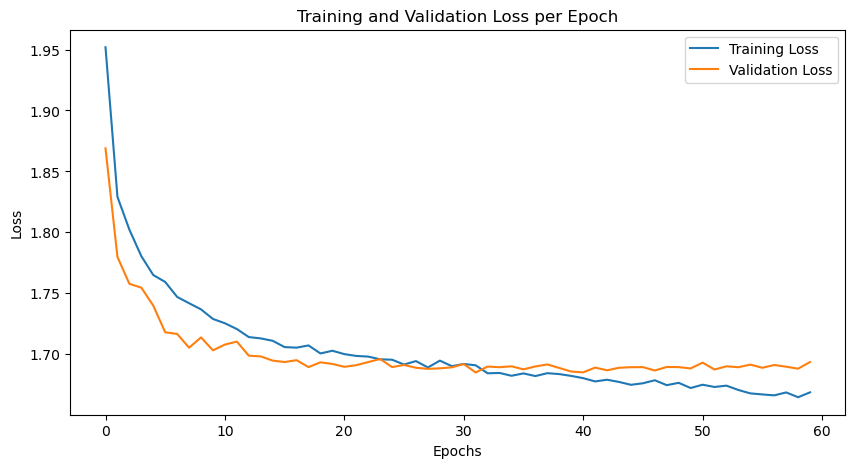

In [346]:
train(train_loader, valid_loader, model, criterion, optimizer,
      device, num_epochs, model_path)

### Model testing & Evaluation metrics

In [347]:
test(test_loader, model, criterion, device, 6)

100%|███████████████████████████████████████████| 67/67 [00:03<00:00, 17.04it/s]


Test Loss: 1.6931395815379584
Confusion Matrix:
[[390 114 339  53  24   0 151]
 [208 289 135  24  26   0 102]
 [183  48 955  57  57   0 402]
 [205  54 475 123  57   0 373]
 [ 90  31 253  65 169   0 437]
 [ 66  26 169  23  10   0 155]
 [114  48 480  85 122   0 813]]
Precision per class: [0.3105095541401274, 0.4737704918032787, 0.3403421240199572, 0.28604651162790695, 0.3634408602150538, 0.0]
Recall per class: [0.3641456582633053, 0.36862244897959184, 0.5611045828437132, 0.09557109557109557, 0.16172248803827752, 0.0]
F1 score per class: [0.335195530726257, 0.4146341463414634, 0.42369121561668144, 0.1432731508444962, 0.223841059602649, 0.0]


### After evaluating the model performance, the second dataset will be used, following the whole process

## Process glove embeddings
---

In [348]:
with open(glove_vector_path, "rt") as f:
    emb = f.readlines()

In [349]:
vocabulary, embeddings = [], []

for item in emb:
    vocabulary.append(item.split()[0])
    embeddings.append(item.split()[1:])

In [350]:
embeddings = np.array(embeddings, dtype=np.float32)

In [351]:
vocabulary = ["<pad>", "<unk>"] + vocabulary

In [352]:
embeddings = np.vstack([np.ones(50, dtype=np.float32), 
                        np.mean(embeddings, axis=0),
                        embeddings])

In [353]:
save_file(embeddings_path, embeddings)
save_file(vocabulary_path, vocabulary)

## Process text data
---

In [354]:
data = df_final

In [355]:
data.dropna(subset=[text_col_name_2], inplace=True) #Drop NA values

### Encode labels


In [356]:
label_encoder = LabelEncoder()
label_encoder.fit(data[label_col_2])
labels = label_encoder.transform(data[label_col_2])

In [357]:
save_file(labels_path, labels)
save_file(label_encoder_path, label_encoder)

In [358]:
print(labels)

[4 4 0 ... 2 2 1]


### Process the text column


In [359]:
input_text = list(data[text_col_name_2])

In [360]:
len(input_text)

20000

### Convert text to lower case

In [361]:
input_text = [i.lower() for i in tqdm(input_text)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 144492.91it/s]


### Remove punctuations except apostrophe

In [362]:
input_text = [re.sub(r"[^\w\d'\s]+", " ", i) 
              for i in tqdm(input_text)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 176569.19it/s]


### Remove digits


In [363]:
input_text = [re.sub("\d+", "", i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 243332.85it/s]


### Remove more than one consecutive instance of 'x'


In [364]:
input_text = [re.sub(r'[x]{2,}', "", i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 302178.93it/s]


### Remove multiple spaces with single space

In [365]:
input_text = [re.sub(' +', ' ', i) for i in tqdm(input_text)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 124627.77it/s]


### Tokenize the text


In [366]:
tokens = [word_tokenize(t) for t in tqdm(input_text)]

100%|███████████████████████████████████| 20000/20000 [00:03<00:00, 5173.67it/s]


### Take the first 20 tokens in each complaint text


In [367]:
print(tokens[1])

['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']


In [368]:
tokens = [i[:20] if len(i) > 19 else ['<pad>'] * (20 - len(i)) + i 
          for i in tqdm(tokens)]

100%|█████████████████████████████████| 20000/20000 [00:00<00:00, 215307.82it/s]


### Convert tokens to integer indices from vocabulary


In [369]:
def token_index(tokens, vocabulary, missing='<unk>'):
    idx_token = []
    for text in tqdm(tokens):
        idx_text = []
        for token in text:
            if token in vocabulary:
                idx_text.append(vocabulary.index(token))
            else:
                idx_text.append(vocabulary.index(missing))
        idx_token.append(idx_text)
    return idx_token

In [370]:
tokens = token_index(tokens, vocabulary)

100%|████████████████████████████████████| 20000/20000 [02:58<00:00, 112.01it/s]


### Save the tokens

In [371]:
save_file(tokens_path, tokens)

## Create attention model
---

In [372]:
class AttentionModel(nn.Module):

    def __init__(self, vec_len, seq_len, n_classes):
        super(AttentionModel, self).__init__()
        self.vec_len = vec_len
        self.seq_len = seq_len
        self.attn_weights = torch.cat([torch.tensor([[0.]]),
                                       torch.randn(vec_len, 1) /
                                       torch.sqrt(torch.tensor(vec_len))])
        self.attn_weights.requires_grad = True
        self.attn_weights = nn.Parameter(self.attn_weights)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm((vec_len + 1,))
        
        self.linear1 = nn.Linear(vec_len + 1, 5000)
        self.norm2 = nn.LayerNorm((5000,))
        self.linear2 = nn.Linear(5000, 2000)
        self.norm3 = nn.LayerNorm((2000,))
        self.linear3 = nn.Linear(2000, 1000)
        self.norm4 = nn.LayerNorm((1000,))
        self.linear4 = nn.Linear(1000, n_classes)

    def forward(self, input_data):
        hidden = torch.matmul(input_data, self.attn_weights)
        hidden = self.activation(hidden)
        attn = self.softmax(hidden)
        attn = attn.repeat(1, 1, self.vec_len + 1).reshape(attn.shape[0],
                                                           self.seq_len,
                                                           self.vec_len + 1)
        attn_output = input_data * attn
        attn_output = torch.sum(attn_output, axis=1)
        
        attn_output = self.norm1(attn_output)
        attn_output = self.dropout(attn_output)
        
        hidden_output = self.linear1(attn_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm2(hidden_output)
        hidden_output = self.dropout(hidden_output)
        
        hidden_output = self.linear2(hidden_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm3(hidden_output)
        hidden_output = self.dropout(hidden_output)
        
        hidden_output = self.linear3(hidden_output)
        hidden_output = self.activation(hidden_output)
        
        hidden_output = self.norm4(hidden_output)
        output = self.linear4(hidden_output)
        
        return output

## Create PyTorch dataset
---

In [373]:
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, tokens, embeddings, labels):
        self.tokens = tokens
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[self.tokens[idx], :])
        input_ = torch.cat((torch.ones(emb.shape[0],1), emb), dim=1)
        return torch.tensor(self.labels[idx]), input_

### Function to train the model

In [374]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          device, num_epochs, model_path):
    best_loss = 1e8
    epoch_train_losses = []
    epoch_valid_losses = []

    for i in range(num_epochs):
        print(f"Epoch {i+1} of {num_epochs}")
        valid_loss, train_loss = [], []
        model.train()
        # Train loop
        for batch_labels, batch_data in tqdm(train_loader):
            batch_labels = batch_labels.to(device)
            batch_data = batch_data.to(device)
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            loss = criterion(batch_output, batch_labels)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        # Validation loop
        for batch_labels, batch_data in tqdm(valid_loader):
            batch_labels = batch_labels.to(device)
            batch_data = batch_data.to(device)
            batch_output = model(batch_data)
            batch_output = torch.squeeze(batch_output)
            loss = criterion(batch_output, batch_labels)
            valid_loss.append(loss.item())

        t_loss = np.mean(train_loss)
        v_loss = np.mean(valid_loss)
        epoch_train_losses.append(t_loss)
        epoch_valid_losses.append(v_loss)

        print(f"Train Loss: {t_loss}, Validation Loss: {v_loss}")

        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), model_path)

        print(f"Best Validation Loss: {best_loss}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_train_losses, label='Training Loss')
    plt.plot(epoch_valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.show()

### Function to test the model

In [375]:
from sklearn.metrics import f1_score

def test(test_loader, model, criterion, device, num_classes):
    model.eval()
    test_loss = []
    true_labels = []
    predicted_labels = []

    # Initialize arrays to store precision, recall, and F1 score for each class
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for batch_labels, batch_data in tqdm(test_loader):
        # Move data to device
        batch_labels = batch_labels.to(device)
        batch_data = batch_data.to(device)
        # Forward pass
        batch_output = model(batch_data)
        batch_output = torch.squeeze(batch_output)
        # Calculate loss
        loss = criterion(batch_output, batch_labels)
        test_loss.append(loss.item())
        batch_preds = torch.argmax(batch_output, axis=1)
        # Move predictions to CPU
        if torch.cuda.is_available():
            batch_labels = batch_labels.cpu()
            batch_preds = batch_preds.cpu()
        # Collect true and predicted labels
        true_labels.extend(batch_labels.detach().numpy())
        predicted_labels.extend(batch_preds.detach().numpy())

    test_loss = np.mean(test_loss)
    print(f"Test Loss: {test_loss}")

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate precision, recall, and F1 score for each class
    for i in range(num_classes):
        precision = precision_score(true_labels, predicted_labels, labels=[i], average='micro')
        recall = recall_score(true_labels, predicted_labels, labels=[i], average='micro')
        f1 = f1_score(true_labels, predicted_labels, labels=[i], average='micro')
        precision_per_class.append(precision)
        recall_per_class.append(recall)
        
        f1_per_class.append(f1)

    print("Precision per class:", precision_per_class)
    print("Recall per class:", recall_per_class)
    print("F1 score per class:", f1_per_class)

## Train attention model
---

### Load the files

In [376]:
tokens = load_file(tokens_path)
labels = load_file(labels_path)
embeddings = load_file(embeddings_path)
label_encoder = load_file(label_encoder_path)
num_classes = len(label_encoder.classes_)
vocabulary = load_file(vocabulary_path)

### Split dataset into train, validation and test sets

In [377]:
X_train, X_test, y_train, y_test = train_test_split(tokens, labels,
                                                    test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train,
                                                     test_size=0.25)

### Create PyTorch datasets

In [378]:
train_dataset = TextDataset(X_train, embeddings, y_train)
valid_dataset = TextDataset(X_valid, embeddings, y_valid)
test_dataset = TextDataset(X_test, embeddings, y_test)

### Create data loaders

In [379]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=120,
                                           shuffle=True, 
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=120)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=120)

In [381]:
# Order for the confusion matrix
class_order = data['Emotion'].unique()
print("Order of classes:", class_order)

Order of classes: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


### Create model object

In [382]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

In [383]:
model = AttentionModel(vec_len, seq_len, num_classes)

### Visualize model architecture

In [384]:
print(model)

AttentionModel(
  (activation): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (norm1): LayerNorm((51,), eps=1e-05, elementwise_affine=True)
  (linear1): Linear(in_features=51, out_features=5000, bias=True)
  (norm2): LayerNorm((5000,), eps=1e-05, elementwise_affine=True)
  (linear2): Linear(in_features=5000, out_features=2000, bias=True)
  (norm3): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
  (linear3): Linear(in_features=2000, out_features=1000, bias=True)
  (norm4): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (linear4): Linear(in_features=1000, out_features=6, bias=True)
)


In [385]:
summary(model, input_size=(seq_len, vec_len + 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1                [-1, 20, 1]               0
           Softmax-2                [-1, 20, 1]               0
         LayerNorm-3                   [-1, 51]             102
           Dropout-4                   [-1, 51]               0
            Linear-5                 [-1, 5000]         260,000
              ReLU-6                 [-1, 5000]               0
         LayerNorm-7                 [-1, 5000]          10,000
           Dropout-8                 [-1, 5000]               0
            Linear-9                 [-1, 2000]      10,002,000
             ReLU-10                 [-1, 2000]               0
        LayerNorm-11                 [-1, 2000]           4,000
          Dropout-12                 [-1, 2000]               0
           Linear-13                 [-1, 1000]       2,001,000
             ReLU-14                 [-

### Define loss function and optimizer

In [386]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Model training

Epoch 1 of 60


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 29.87it/s]


Train Loss: 1.7703236281871795, Validation Loss: 1.6110096047906315
Best Validation Loss: 1.6110096047906315
Epoch 2 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.04it/s]


Train Loss: 1.58642142534256, Validation Loss: 1.6116672193302828
Best Validation Loss: 1.6110096047906315
Epoch 3 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.85it/s]


Train Loss: 1.520735765695572, Validation Loss: 1.3816739916801453
Best Validation Loss: 1.3816739916801453
Epoch 4 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.84it/s]


Train Loss: 1.408519617319107, Validation Loss: 1.2448090244742
Best Validation Loss: 1.2448090244742
Epoch 5 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.92it/s]


Train Loss: 1.3258595013618468, Validation Loss: 1.1648795797544367
Best Validation Loss: 1.1648795797544367
Epoch 6 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.34it/s]


Train Loss: 1.2800507199764253, Validation Loss: 1.0866111832506515
Best Validation Loss: 1.0866111832506515
Epoch 7 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.02it/s]


Train Loss: 1.2311818051338195, Validation Loss: 1.0133085741716272
Best Validation Loss: 1.0133085741716272
Epoch 8 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.85it/s]


Train Loss: 1.1893534857034682, Validation Loss: 0.9641651388476876
Best Validation Loss: 0.9641651388476876
Epoch 9 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.99it/s]


Train Loss: 1.1401214200258254, Validation Loss: 0.9203002908650566
Best Validation Loss: 0.9203002908650566
Epoch 10 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.26it/s]


Train Loss: 1.1083918803930282, Validation Loss: 0.8970195949077606
Best Validation Loss: 0.8970195949077606
Epoch 11 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.04it/s]


Train Loss: 1.0795103776454926, Validation Loss: 0.8654395026319167
Best Validation Loss: 0.8654395026319167
Epoch 12 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.22it/s]


Train Loss: 1.0497389340400696, Validation Loss: 0.8297164036947138
Best Validation Loss: 0.8297164036947138
Epoch 13 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.26it/s]


Train Loss: 1.0197838002443314, Validation Loss: 0.8091002948143903
Best Validation Loss: 0.8091002948143903
Epoch 14 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.68it/s]


Train Loss: 0.9922838062047958, Validation Loss: 0.7838748535689186
Best Validation Loss: 0.7838748535689186
Epoch 15 of 60


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 31.94it/s]


Train Loss: 0.9684282273054123, Validation Loss: 0.7642671676243052
Best Validation Loss: 0.7642671676243052
Epoch 16 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.49it/s]


Train Loss: 0.9637169992923736, Validation Loss: 0.7665708941571853
Best Validation Loss: 0.7642671676243052
Epoch 17 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.88it/s]


Train Loss: 0.9361754620075226, Validation Loss: 0.7398342455134672
Best Validation Loss: 0.7398342455134672
Epoch 18 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.73it/s]


Train Loss: 0.9193788152933121, Validation Loss: 0.7363291417851168
Best Validation Loss: 0.7363291417851168
Epoch 19 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.11it/s]


Train Loss: 0.9108257550001144, Validation Loss: 0.7257392441525179
Best Validation Loss: 0.7257392441525179
Epoch 20 of 60


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 25.71it/s]


Train Loss: 0.9052145737409591, Validation Loss: 0.7215795429313884
Best Validation Loss: 0.7215795429313884
Epoch 21 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.50it/s]


Train Loss: 0.8797384113073349, Validation Loss: 0.7140333284350002
Best Validation Loss: 0.7140333284350002
Epoch 22 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.12it/s]


Train Loss: 0.8700423723459244, Validation Loss: 0.7177161898683099
Best Validation Loss: 0.7140333284350002
Epoch 23 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.15it/s]


Train Loss: 0.8642819440364837, Validation Loss: 0.7085321510539335
Best Validation Loss: 0.7085321510539335
Epoch 24 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.33it/s]


Train Loss: 0.8532026952505112, Validation Loss: 0.7044088384684395
Best Validation Loss: 0.7044088384684395
Epoch 25 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.42it/s]


Train Loss: 0.8463479554653168, Validation Loss: 0.7092986808103674
Best Validation Loss: 0.7044088384684395
Epoch 26 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.77it/s]


Train Loss: 0.8458779501914978, Validation Loss: 0.6987218725330689
Best Validation Loss: 0.6987218725330689
Epoch 27 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.39it/s]


Train Loss: 0.8274495643377304, Validation Loss: 0.7077029925935409
Best Validation Loss: 0.6987218725330689
Epoch 28 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.81it/s]


Train Loss: 0.8277052801847458, Validation Loss: 0.7011381045860403
Best Validation Loss: 0.6987218725330689
Epoch 29 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.21it/s]


Train Loss: 0.8326888924837113, Validation Loss: 0.6978960808585671
Best Validation Loss: 0.6978960808585671
Epoch 30 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.65it/s]


Train Loss: 0.8190461724996567, Validation Loss: 0.6907184991766425
Best Validation Loss: 0.6907184991766425
Epoch 31 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.39it/s]


Train Loss: 0.810019770860672, Validation Loss: 0.6979163630920298
Best Validation Loss: 0.6907184991766425
Epoch 32 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.13it/s]


Train Loss: 0.8118687158823014, Validation Loss: 0.6937922081526589
Best Validation Loss: 0.6907184991766425
Epoch 33 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.05it/s]


Train Loss: 0.7985950338840485, Validation Loss: 0.6839581175762064
Best Validation Loss: 0.6839581175762064
Epoch 34 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.35it/s]


Train Loss: 0.7944503021240235, Validation Loss: 0.6887732139405083
Best Validation Loss: 0.6839581175762064
Epoch 35 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.97it/s]


Train Loss: 0.7959165060520172, Validation Loss: 0.6863973552689833
Best Validation Loss: 0.6839581175762064
Epoch 36 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 35.11it/s]


Train Loss: 0.7901779663562775, Validation Loss: 0.6848247384323793
Best Validation Loss: 0.6839581175762064
Epoch 37 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.52it/s]


Train Loss: 0.7807175356149674, Validation Loss: 0.6804558047476936
Best Validation Loss: 0.6804558047476936
Epoch 38 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.87it/s]


Train Loss: 0.7743509435653686, Validation Loss: 0.6880396902561188
Best Validation Loss: 0.6804558047476936
Epoch 39 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.79it/s]


Train Loss: 0.7702028250694275, Validation Loss: 0.6924555520800983
Best Validation Loss: 0.6804558047476936
Epoch 40 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.02it/s]


Train Loss: 0.773379727602005, Validation Loss: 0.6874659885378445
Best Validation Loss: 0.6804558047476936
Epoch 41 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.91it/s]


Train Loss: 0.7615460640192032, Validation Loss: 0.6876746793003643
Best Validation Loss: 0.6804558047476936
Epoch 42 of 60


100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 30.55it/s]


Train Loss: 0.7675633436441421, Validation Loss: 0.6856809398707222
Best Validation Loss: 0.6804558047476936
Epoch 43 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.53it/s]


Train Loss: 0.7572420185804367, Validation Loss: 0.6861281517673942
Best Validation Loss: 0.6804558047476936
Epoch 44 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 36.59it/s]


Train Loss: 0.7507788932323456, Validation Loss: 0.6943272317157072
Best Validation Loss: 0.6804558047476936
Epoch 45 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.81it/s]


Train Loss: 0.7574971169233322, Validation Loss: 0.6861082429395002
Best Validation Loss: 0.6804558047476936
Epoch 46 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 35.95it/s]


Train Loss: 0.7520854413509369, Validation Loss: 0.6882341854712543
Best Validation Loss: 0.6804558047476936
Epoch 47 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.87it/s]


Train Loss: 0.7421592345833778, Validation Loss: 0.6910408042809543
Best Validation Loss: 0.6804558047476936
Epoch 48 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.61it/s]


Train Loss: 0.7427860915660858, Validation Loss: 0.6921016670325223
Best Validation Loss: 0.6804558047476936
Epoch 49 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.57it/s]


Train Loss: 0.7465032327175141, Validation Loss: 0.6860179313841988
Best Validation Loss: 0.6804558047476936
Epoch 50 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.85it/s]


Train Loss: 0.7404080334305764, Validation Loss: 0.6919982731342316
Best Validation Loss: 0.6804558047476936
Epoch 51 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.13it/s]


Train Loss: 0.7438200816512108, Validation Loss: 0.6910068024607265
Best Validation Loss: 0.6804558047476936
Epoch 52 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.15it/s]


Train Loss: 0.7289138662815094, Validation Loss: 0.6867378205060959
Best Validation Loss: 0.6804558047476936
Epoch 53 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.19it/s]


Train Loss: 0.7318774765729904, Validation Loss: 0.6876375368412804
Best Validation Loss: 0.6804558047476936
Epoch 54 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.48it/s]


Train Loss: 0.719557438492775, Validation Loss: 0.6980961140464333
Best Validation Loss: 0.6804558047476936
Epoch 55 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.90it/s]


Train Loss: 0.7360331135988235, Validation Loss: 0.6892375946044922
Best Validation Loss: 0.6804558047476936
Epoch 56 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 38.51it/s]


Train Loss: 0.7273209047317505, Validation Loss: 0.6860274909173741
Best Validation Loss: 0.6804558047476936
Epoch 57 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 37.89it/s]


Train Loss: 0.7228785961866379, Validation Loss: 0.6885302189518424
Best Validation Loss: 0.6804558047476936
Epoch 58 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.16it/s]


Train Loss: 0.7189516499638557, Validation Loss: 0.692085779765073
Best Validation Loss: 0.6804558047476936
Epoch 59 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.31it/s]


Train Loss: 0.7190242356061936, Validation Loss: 0.6962648901869269
Best Validation Loss: 0.6804558047476936
Epoch 60 of 60


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.03it/s]


Train Loss: 0.7142533671855926, Validation Loss: 0.6921815048245823
Best Validation Loss: 0.6804558047476936


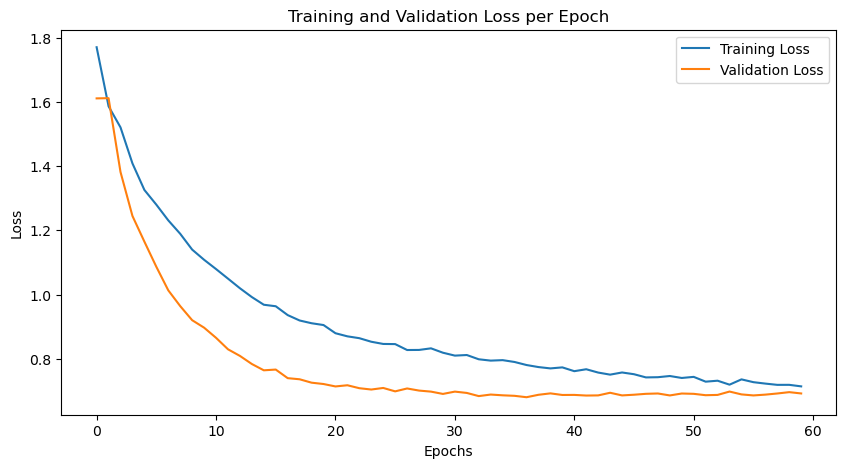

In [387]:
train(train_loader, valid_loader, model, criterion, optimizer,
      device, num_epochs, model_path)

### Model testing & Evaluation metrics

In [388]:
test(test_loader, model, criterion, device, 6)

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 32.07it/s]


Test Loss: 0.7059355097658494
Confusion Matrix:
[[ 407   12   67    3   64    0]
 [  22  333   49    1   43    9]
 [  31   26 1171   39  106    7]
 [   6    4  100  197   23    0]
 [  26    9  203   16  897    5]
 [   1   21   26    0    7   69]]
Precision per class: [0.8255578093306288, 0.8222222222222222, 0.7246287128712872, 0.76953125, 0.7868421052631579, 0.7666666666666667]
Recall per class: [0.7359855334538878, 0.7286652078774617, 0.8485507246376811, 0.5969696969696969, 0.7759515570934256, 0.5564516129032258]
F1 score per class: [0.7782026768642448, 0.7726218097447797, 0.7817089452603472, 0.6723549488054608, 0.7813588850174216, 0.644859813084112]


## Predict on new text
---

In [389]:
input_text = '''I'm cancelling my 2 Cybertruck reservations because I just got scammed on a Y purchase. 3/3 reps I talked to (and asked repeatedly) said my 2016 autopilot would transfer to FSD in my new Y purchase. Then AFTER I wired the full payment, they re-negged on the deal.  Now ghosting me'''

### Process input text

In [390]:
input_text = input_text.lower()
input_text = re.sub(r"[^\w\d'\s]+", " ", input_text)
input_text = re.sub("\d+", "", input_text)
input_text = re.sub(r'[x]{2,}', "", input_text)
input_text = re.sub(' +', ' ', input_text)
tokens = word_tokenize(input_text)

In [391]:
tokens = ['<pad>']*(20-len(tokens))+tokens

In [392]:
idx_token = []
for token in tokens:
    if token in vocabulary:
        idx_token.append(vocabulary.index(token))
    else:
        idx_token.append(vocabulary.index('<unk>'))

In [393]:
token_emb = embeddings[idx_token,:]
token_emb = token_emb[:seq_len, :]
input_ind = torch.from_numpy(token_emb)

In [394]:
input_ind = torch.cat((torch.ones(input_ind.shape[0],1), input_ind), dim=1)

In [395]:
device = torch.device("cuda:0" if torch.cuda.is_available() 
                      else "cpu")

In [396]:
input_ind = input_ind.to(device)
input_ind = torch.unsqueeze(input_ind, 0)

In [397]:
label_encoder = load_file(label_encoder_path)
num_classes = len(label_encoder.classes_)

### Model prediction

In [398]:
# Create model object
model = AttentionModel(vec_len, seq_len, num_classes)

# Load trained weights
model.load_state_dict(torch.load(model_path))

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    
# Forward pass
out = torch.squeeze(model(input_ind))

# Find predicted class
prediction = label_encoder.classes_[torch.argmax(out)]
print(f"Predicted  Class: {prediction}")

Predicted  Class: joy
